Using this Kaggle data create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

In [353]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import preprocessing, decomposition
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

In [354]:
# Read and import data
housing = pd.read_csv('Melbourne_housing_FULL.csv')
housing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [355]:
#Check the columns in the raw data
housing.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [356]:
#Check the kind of variables in the raw data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29217 entries, 0 to 29216
Data columns (total 21 columns):
Suburb           29217 non-null object
Address          29217 non-null object
Rooms            29217 non-null int64
Type             29217 non-null object
Price            22850 non-null float64
Method           29217 non-null object
SellerG          29217 non-null object
Date             29217 non-null object
Distance         29217 non-null float64
Postcode         29217 non-null int64
Bedroom2         22665 non-null float64
Bathroom         22659 non-null float64
Car              22357 non-null float64
Landsize         19649 non-null float64
BuildingArea     11817 non-null float64
YearBuilt        13473 non-null float64
CouncilArea      29215 non-null object
Lattitude        22878 non-null float64
Longtitude       22878 non-null float64
Regionname       29215 non-null object
Propertycount    29215 non-null float64
dtypes: float64(11), int64(2), object(8)
memory usage: 4.7+ MB


In [357]:
print(housing.isnull().sum())
print(len(housing))

Suburb               0
Address              0
Rooms                0
Type                 0
Price             6367
Method               0
SellerG              0
Date                 0
Distance             0
Postcode             0
Bedroom2          6552
Bathroom          6558
Car               6860
Landsize          9568
BuildingArea     17400
YearBuilt        15744
CouncilArea          2
Lattitude         6339
Longtitude        6339
Regionname           2
Propertycount        2
dtype: int64
29217


In [358]:
#Eliminate the rows that have no info regarding price
housing1 = housing[np.isfinite(housing['Price'])] 

#Transform the data into datetime
housing1['Date'] = pd.to_datetime(housing['Date'])

#Transform the date into months and year
housing1['Month'] = housing1['Date'].dt.month
housing1['Year'] = housing1['Date'].dt.year

#Delete the property count
del housing1['Propertycount']

D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Users\Borja.gonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [359]:
#Understand the time span of the data
housing1.Date.min(), housing1.Date.max()

(Timestamp('2016-01-28 00:00:00'), Timestamp('2017-12-08 00:00:00'))

In [360]:
#Consider only the sales that have taken place within the last year of data (12 months)
mask = (housing1['Date'] > '2016-12-08')
housing2 = housing1.loc[mask]

In [361]:
#Check the Nan values that are still remaining
print(housing2.isnull().sum())
print(len(housing2))

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bedroom2        3495
Bathroom        3499
Car             3729
Landsize        5872
BuildingArea    9449
YearBuilt       8653
CouncilArea        2
Lattitude       3380
Longtitude      3380
Regionname         2
Month              0
Year               0
dtype: int64
15178


In [362]:
#Drop the Nan values that are in the Regionname and CouncilArea columns and 
#Fill the missing values with the median of each column
housing3 = housing2.dropna(subset=[['Regionname','CouncilArea']])
housing4 = housing3.fillna(housing2.median())

In [363]:
#Check that there is no Nan value
print(housing4.isnull().sum())
print(len(housing4))

Suburb          0
Address         0
Rooms           0
Type            0
Price           0
Method          0
SellerG         0
Date            0
Distance        0
Postcode        0
Bedroom2        0
Bathroom        0
Car             0
Landsize        0
BuildingArea    0
YearBuilt       0
CouncilArea     0
Lattitude       0
Longtitude      0
Regionname      0
Month           0
Year            0
dtype: int64
15176


In [364]:
#Check the type of info regarding each variable
housing4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15176 entries, 4 to 29216
Data columns (total 22 columns):
Suburb          15176 non-null object
Address         15176 non-null object
Rooms           15176 non-null int64
Type            15176 non-null object
Price           15176 non-null float64
Method          15176 non-null object
SellerG         15176 non-null object
Date            15176 non-null datetime64[ns]
Distance        15176 non-null float64
Postcode        15176 non-null int64
Bedroom2        15176 non-null float64
Bathroom        15176 non-null float64
Car             15176 non-null float64
Landsize        15176 non-null float64
BuildingArea    15176 non-null float64
YearBuilt       15176 non-null float64
CouncilArea     15176 non-null object
Lattitude       15176 non-null float64
Longtitude      15176 non-null float64
Regionname      15176 non-null object
Month           15176 non-null int64
Year            15176 non-null int64
dtypes: datetime64[ns](1), float64(10), i

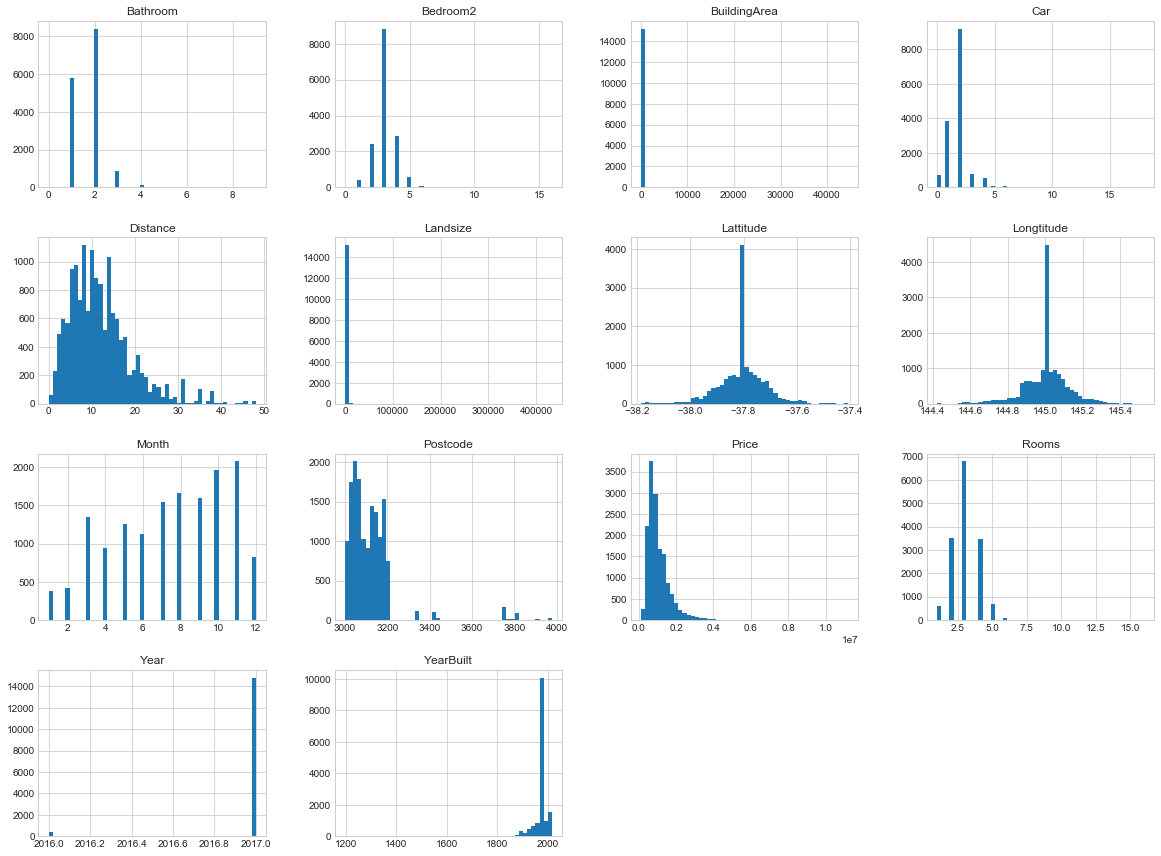

In [365]:
#Plot the relationship between the numeric variables
housing4.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

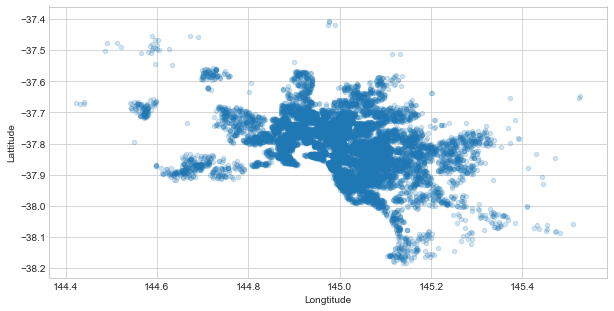

In [366]:
#Plot the longitituda and lattitude to improve the nderstanding of the area
housing4.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.2, figsize=(10,5))

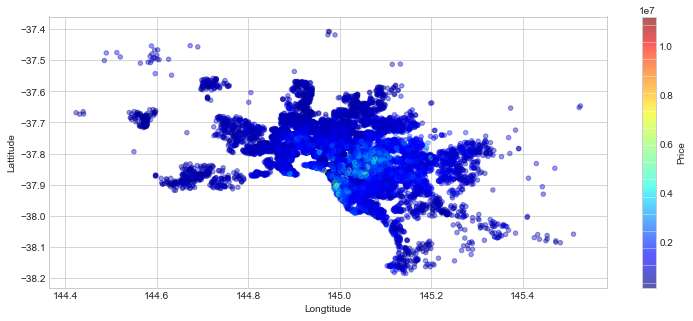

In [367]:
#Plot the prices agasint longtitude and lattitude. Understand the concentration of high prices within regions in Melbourne
housing4.plot(kind="scatter", x="Longtitude", y="Lattitude",
              alpha=0.4, figsize=(12.5,5), c="Price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

In [368]:
#Create new features: One that is the price per built_area and the other one to eliminate the skweness of price
housing4['Price_per_buildingarea'] = housing4['Price']/(housing4['BuildingArea']+1)
housing4['logPrice']  = np.log(housing4['Price'])

In [369]:
#Understand the number of Regions and Suburbs to create a categorical features that classifies 
#the most convenient one according to the price
print('Number of Suburbs:', len(housing4['Suburb'].value_counts()))
print('Number of Regions: ' , len(housing4['Regionname'].value_counts()))

Number of Suburbs: 340
Number of Regions:  8


In [370]:
#Create the clusters of neighbouhoods/suburbs as it will give the adequate level of granularity
#Consider prices and frequency of purchase in each area
freq = housing4.groupby('Suburb').count()['Postcode']
mean = housing4.groupby('Suburb').median()['Price_per_buildingarea']
cluster = pd.concat([freq, mean], axis=1)
cluster['Suburb'] = cluster.index
cluster.columns = ['freq', 'Price_per_buildingarea','Suburb']
cluster.describe()

,freq,Price_per_buildingarea
count,340.000000,340.000000
mean,44.635294,6468.731773
std,47.723972,2335.770864
min,1.000000,2649.253731
25%,10.000000,4690.226171
50%,30.000000,6035.536603
75%,61.250000,8047.450249
max,351.000000,15815.389032


In [371]:
#Divide into 2 clusters: Moderate and Expensive according to price. Create the moderate cluster
cluster1 = cluster[cluster.Price_per_buildingarea <= 6131]
cluster1.index

Index(['Airport West', 'Albanvale', 'Albion', 'Altona Meadows', 'Altona North',
       'Ardeer', 'Attwood', 'Bacchus Marsh', 'Balaclava', 'Bayswater',
       ...
       'Werribee South', 'Westmeadows', 'Whittlesea', 'Williams Landing',
       'Wollert', 'Wonga Park', 'Wyndham Vale', 'Yallambie', 'Yarra Glen',
       'croydon'],
      dtype='object', name='Suburb', length=173)

In [372]:
#Create the Expensive cluster
cluster2 = cluster[cluster.Price_per_buildingarea > 6131]
cluster2.index

Index(['Abbotsford', 'Aberfeldie', 'Albert Park', 'Alphington', 'Altona',
       'Armadale', 'Ascot Vale', 'Ashburton', 'Ashwood', 'Aspendale',
       ...
       'Wattle Glen', 'West Footscray', 'West Melbourne', 'Wheelers Hill',
       'Wildwood', 'Williamstown', 'Williamstown North', 'Windsor',
       'Yarraville', 'viewbank'],
      dtype='object', name='Suburb', length=167)

In [373]:
#Add the clusters into the dataset
def get_group(x):
    if x in cluster1.index:
        return 'Moderate'
    else:
        return 'Expensive'
housing4['Neighbourhood'] = housing4.Suburb.apply(get_group)

In [374]:
#Check the features in place after all the data manipulation
housing4.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Month,Year,Price_per_buildingarea,logPrice,Neighbourhood
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067,...,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4,2017,9701.986755,14.197366,Expensive
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-04-03,2.5,3067,...,1970.0,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4,2017,6343.283582,13.652992,Expensive
23,Abbotsford,411/8 Grosvenor St,2,u,700000.0,VB,Jellis,2016-12-11,2.5,3067,...,1970.0,Yarra City Council,-37.8110,145.0067,Northern Metropolitan,12,2016,5223.880597,13.458836,Expensive
24,Abbotsford,40 Nicholson St,3,h,1350000.0,VB,Nelson,2016-12-11,2.5,3067,...,2005.0,Yarra City Council,-37.8085,144.9964,Northern Metropolitan,12,2016,7068.062827,14.115615,Expensive
25,Abbotsford,123/56 Nicholson St,2,u,750000.0,S,Biggin,2016-12-11,2.5,3067,...,2009.0,Yarra City Council,-37.8078,144.9965,Northern Metropolitan,12,2016,7894.736842,13.527828,Expensive


In [375]:
#Check the values for the new features
housing4.Neighbourhood.unique()

array(['Expensive', 'Moderate'], dtype=object)

In [376]:
#Check the relationship between logprice and the rest of the features
corr_matrix = housing4.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price                     1.000000
logPrice                  0.920970
Rooms                     0.433638
Bedroom2                  0.372458
Bathroom                  0.320517
Longtitude                0.160862
Car                       0.152917
Price_per_buildingarea    0.088919
BuildingArea              0.048178
Landsize                  0.023545
Postcode                  0.012942
Month                     0.004795
Year                     -0.008033
Lattitude                -0.182692
YearBuilt                -0.229072
Distance                 -0.241333
Name: Price, dtype: float64

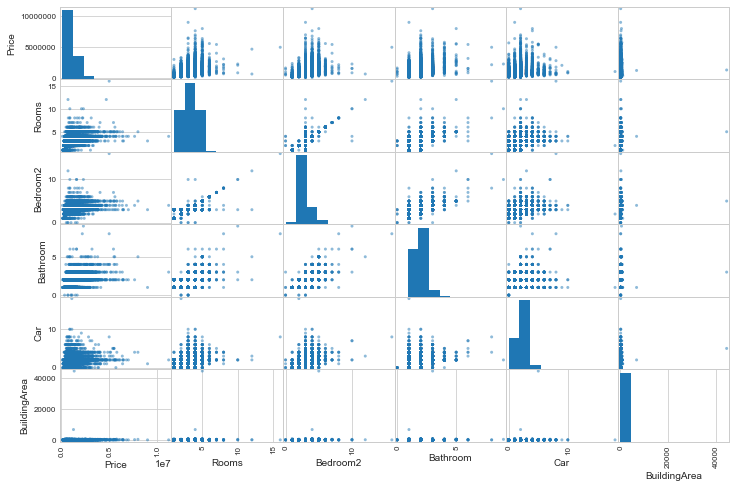

In [377]:
#Plot the relationship between all the numercial features
from pandas.plotting import scatter_matrix

attributes = ["Price", "Rooms", "Bedroom2", "Bathroom",'Car','BuildingArea']
scatter_matrix(housing4[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

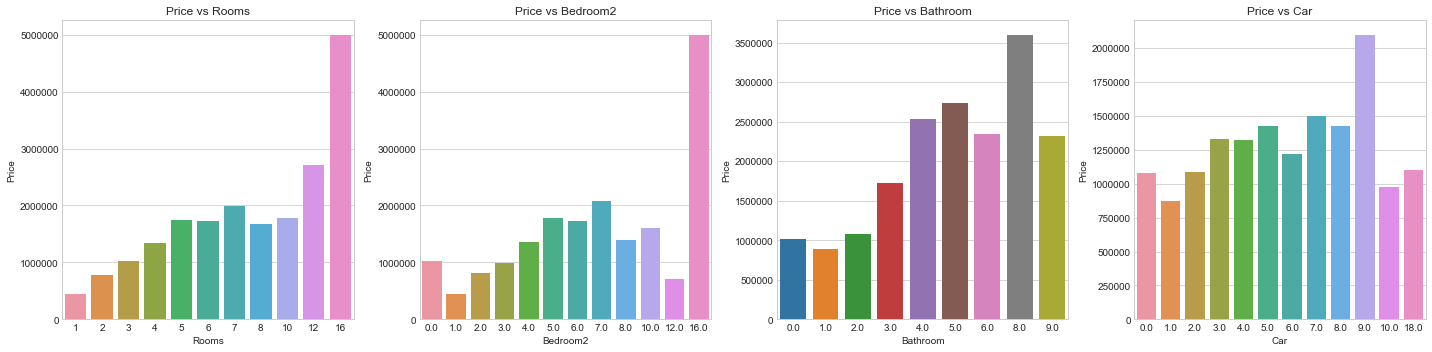

In [378]:
#Visualize the relationship between log Price and the most correlated variables.

plt.figure(figsize=(20, 5))
sns.set_style("whitegrid")

plt.subplot(1, 4, 1)
ax = sns.barplot(x="Rooms", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Rooms')

plt.subplot(1, 4, 2)
ax = sns.barplot(x="Bedroom2", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Bedroom2')

plt.subplot(1, 4, 3)
ax = sns.barplot(x="Bathroom", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Bathroom')

plt.subplot(1, 4, 4)
ax = sns.barplot(x="Car", y="Price", data=housing4, ci=None)
plt.ylabel("Price")
plt.title('Price vs Car')

plt.tight_layout()
plt.show()

In [379]:
#Check all the columns in the manipulated dataframe
housing4.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Month', 'Year', 'Price_per_buildingarea',
       'logPrice', 'Neighbourhood'],
      dtype='object')

In [380]:
#Create a new dataframe that incorporates the new variable Neghibourhood and eliminates the data that is not useful
housing5 = housing4.drop(['Suburb', 'Address', 'Method', 'SellerG', 'Date',
                                   'Distance','Postcode', 'CouncilArea', 
                                   'Lattitude','Longtitude','Regionname','Month','Year'],axis=1)
housing5.describe()

,Rooms,Price,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Price_per_buildingarea,logPrice
count,15176.000000,1.517600e+04,15176.000000,15176.000000,15176.000000,15176.000000,15176.000000,15176.000000,1.517600e+04,15176.000000
mean,3.034133,1.053772e+06,3.072483,1.694122,1.812269,634.157222,143.083378,1969.767923,1.202270e+04,13.729041
std,0.953631,6.418057e+05,0.837438,0.632357,0.888148,3977.106959,368.075439,23.674243,7.814659e+04,0.510943
min,1.000000,1.210000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,3.043849e+01,11.703546
25%,2.000000,6.410000e+05,3.000000,1.000000,1.000000,450.000000,133.000000,1970.000000,4.880743e+03,13.370785
50%,3.000000,8.800000e+05,3.000000,2.000000,2.000000,543.000000,133.000000,1970.000000,6.716418e+03,13.687677
75%,4.000000,1.300000e+06,3.000000,2.000000,2.000000,596.000000,133.000000,1970.000000,9.418505e+03,14.077875
max,16.000000,1.120000e+07,16.000000,9.000000,18.000000,433014.000000,44515.000000,2017.000000,3.450000e+06,16.231424


In [381]:
#Eliminate outliers

housing5 = housing5[housing5.Rooms < 10].reset_index(drop=True)

#Describe the dataset
housing5.describe()


,Rooms,Price,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Price_per_buildingarea,logPrice
count,15170.000000,1.517000e+04,15170.000000,15170.000000,15170.000000,15170.000000,15170.000000,15170.000000,1.517000e+04,15170.000000
mean,3.030719,1.053152e+06,3.070138,1.692881,1.811734,634.176401,143.059482,1969.762492,1.202067e+04,13.728724
std,0.937273,6.403011e+05,0.823999,0.626935,0.886844,3977.891495,368.138282,23.674247,7.816148e+04,0.510582
min,1.000000,1.210000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,3.043849e+01,11.703546
25%,2.000000,6.410000e+05,3.000000,1.000000,1.000000,450.000000,133.000000,1970.000000,4.880646e+03,13.370785
50%,3.000000,8.800000e+05,3.000000,2.000000,2.000000,543.000000,133.000000,1970.000000,6.716418e+03,13.687677
75%,4.000000,1.300000e+06,3.000000,2.000000,2.000000,596.000000,133.000000,1970.000000,9.417616e+03,14.077875
max,8.000000,1.120000e+07,10.000000,8.000000,18.000000,433014.000000,44515.000000,2017.000000,3.450000e+06,16.231424


In [382]:
#Create the predicted and predictors for the model
X = housing5.drop(['Price','logPrice'],axis=1)
Y = housing5['logPrice']

#Substitute categorical variables Type and Neighbourhood for dummies
n = pd.get_dummies(X.Neighbourhood)
X = pd.concat([X, n], axis=1)
m = pd.get_dummies(X.Type)
X = pd.concat([X, m], axis=1)
drops = ['Neighbourhood', 'Type']
X.drop(drops, inplace=True, axis=1)

In [383]:
#Pre-process the data
names = X.columns
X1 = pd.DataFrame(preprocessing.scale(X), columns = names)

In [384]:
#Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.3, random_state=0)

#Initiating the cross validation generator, N splits = 5
kf = KFold(5)

***Linear Regression model***

In [385]:
#Initialize and fit the Linearregression model

lr = LinearRegression()
fitlr = lr.fit(X_train, y_train)

print(lr.coef_)
cross_val_score(lr, X_train, y_train, cv=kf).mean()

[  2.02952271e-01  -7.21458776e-02   6.97734112e-02   2.23089411e-02
   6.97137246e-03   1.42674083e-01  -6.58917628e-02   2.13374071e-02
   1.05959489e+12   1.05959489e+12  -2.66044687e+11  -1.75558063e+11
  -2.32399924e+11]


0.59638618810303967

In [386]:
#Predict the value of y
y_pred = lr.predict(X_test)

lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)

Liner Regression RMSE: 0.4000


***PCA Analysis***

In [387]:
# Build up the correlation mtrix
Z = X1
correlation_matrix = Z.corr()

In [388]:
#Eigenvectores & Eigenvalues

eig_vals, eig_vecs = np.linalg.eig(correlation_matrix)

sklearn_pca = PCA(n_components=len(Z.columns))
Y_sklearn = sklearn_pca.fit_transform(correlation_matrix)

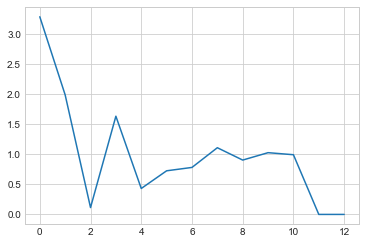

In [389]:
#From the Scree plot.

plt.plot(eig_vals)
plt.show()

In [390]:
#PCA Analysis

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X1)

# Create a PCA object
pca = decomposition.PCA(n_components=5)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

# View the new feature data's shape
X_std_pca.shape

# Create a new dataframe with the new features

XPCA = pd.DataFrame(X_std_pca)
XPCA.head()


,0,1,2,3,4
0,-0.315718,1.464745,2.296264,-0.460782,0.815003
1,0.013264,0.941314,0.694537,-0.195817,0.165834
2,-2.878633,0.413006,-0.583217,0.666333,-0.935474
3,0.341080,0.718074,-0.234466,0.128800,-0.216726
4,-2.867354,0.089063,-1.338854,0.672085,-1.166749


In [391]:
#Fit the Linear Regression model with the PCA features
lr = LinearRegression()
fitlr = lr.fit(XPCA, Y)

print(fitlr.coef_)
cross_val_score(lr, XPCA, Y, cv=kf).mean()

[ 0.10734262  0.23251655  0.06607549 -0.03587458  0.05325662]


0.59663591085314249

In [392]:
#Predict the value of y
y_pred = lr.predict(XPCA)

lin_mse = mean_squared_error(y_pred, Y)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)

Liner Regression RMSE: 0.3221


***Recursive Feature Elimination & PCA***

In [393]:
# create the RFE model and select features

nfeatures = 5
rfe = RFE(lr,nfeatures)
fit = rfe.fit(X1,Y)

# summarize the selection of the features

result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),columns=['Features','Ranking','Support'] )
result_RFE.sort_values('Ranking')

,Features,Ranking,Support
8,Expensive,1,True
9,Moderate,1,True
10,h,1,True
11,t,1,True
12,u,1,True
0,Rooms,2,False
6,YearBuilt,3,False
2,Bathroom,4,False
1,Bedroom2,5,False
3,Car,6,False


In [394]:
#Build Feature for the model
XRFE = X1[['Expensive','Moderate','h','t','u']]

In [395]:
#Fit the Linear Regression model with the PCA features
lr = LinearRegression()
fitlr = lr.fit(XRFE, Y)

print(fitlr.coef_)
cross_val_score(lr, XRFE, Y, cv=kf).mean()

[ -2.96434707e+10  -2.96434707e+10  -1.76971322e+10  -1.16780165e+10
  -1.54591029e+10]


0.49442804203563939

In [396]:
#Predict the value of y
y_pred = lr.predict(XRFE)

lin_mse = mean_squared_error(y_pred, Y)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)

Liner Regression RMSE: 0.3617


***Feature Importance with Random Forest***

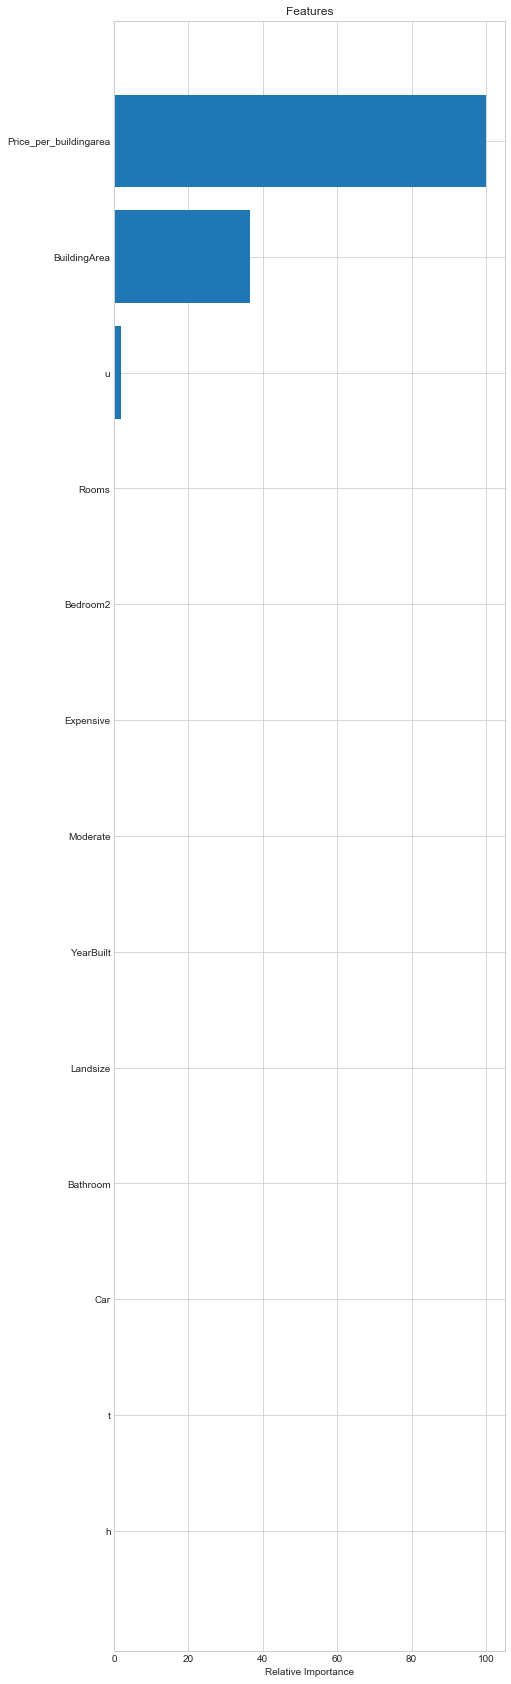

In [397]:
#Calculate Feature Importance using Random Forest
rf = RandomForestRegressor()
rf.fit(X1, Y)

#Define feature importance
feature_importance = rf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(7, 30))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X1.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Features')
plt.show()

In [423]:
#Feature Selection. Scores for the most relevant features (should we start with the one that has more explanatory power)
from sklearn.feature_selection import SelectKBest

# feature extraction
test = SelectKBest()
fit = test.fit(X1, Y)

#Identify features with highest score from a predictive perspective (for all programs)
names2 = X1.columns
Bestfeatures = pd.DataFrame(fit.scores_, index = names2)
Bestfeatures.columns = ['Best Features']
Bestfeatures.sort_values(by=['Best Features'], ascending=False)

,Best Features
Rooms,3.459063
Expensive,3.451900
Moderate,3.451900
u,2.871461
Bedroom2,2.611380
Price_per_buildingarea,2.344780
h,2.153194
Bathroom,1.992744
YearBuilt,1.518611
Car,1.167873


In [398]:
#Build the new features based on Feature Importance
X2 = X1[['Price_per_buildingarea','BuildingArea','u']]
Y2 = Y

In [399]:
#Split between train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.3, random_state=0)

In [400]:
#Fit the Linear Regression model with the PCA features
lr = LinearRegression()
fitlr = lr.fit(X_train2, y_train2)

print(fitlr.coef_)
cross_val_score(lr, X_train2, y_train2, cv=kf).mean()

[ 0.04180841  0.33027357 -0.21084049]


0.13045701015227221

In [401]:
#Predict the value of y
y_pred = lr.predict(X_test2)

lin_mse = mean_squared_error(y_pred,y_test2)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linaer Regression RMSE: 0.7367


***Feature Selection using Lasso***

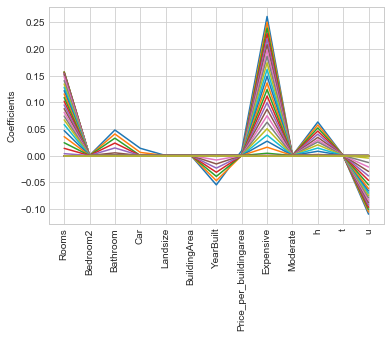

In [402]:
#Feature Selection using Lasso


for lambd in [x * 0.01 for x in range(1, 100)]:
    lasso = Lasso(alpha=lambd)
    lasso_coef = lasso.fit(X1, Y).coef_
    plt.xticks(range(len(names)), names, rotation=90)
    plt.ylabel('Coefficients')
    plt.plot(range(len(names)), lasso_coef)

plt.show()

In [403]:
#Build new set of features
Xl = X1[['Rooms','Bathroom','Car','YearBuilt','Expensive','h','u']]

In [404]:
#Split between train and test
X_trainl, X_testl, y_trainl, y_testl = train_test_split(Xl, Y, test_size=0.3, random_state=0)

In [405]:
#Fit the Linear Regression model with the PCA features
lr = LinearRegression()
fitlr = lr.fit(X_trainl, y_trainl)

print(fitlr.coef_)
cross_val_score(lr, X_trainl, y_trainl, cv=kf).mean()

[ 0.15426743  0.05938789  0.01728838 -0.06199781  0.27189489  0.06720124
 -0.1171208 ]


0.6122587018626201

In [406]:
#Predict the value of y
y_pred = lr.predict(X_testl)

lin_mse = mean_squared_error(y_pred, y_testl)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)
cross_val_score(lr, X_testl, y_testl, cv=kf).mean()

Liner Regression RMSE: 0.3136


0.61964093929640218

***Ridge Regression***

In [407]:
#Inspect columns

X1.columns

Index(['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'YearBuilt', 'Price_per_buildingarea', 'Expensive', 'Moderate', 'h',
       't', 'u'],
      dtype='object')

In [408]:
#Build new set of features

#Try using the whole set of initial features
Xr0 = X1[['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'YearBuilt', 'Price_per_buildingarea', 'Expensive', 'Moderate', 'h',
       't', 'u']]

#Based on the values of the coefficients, take the meaningful features
Xr1 = X1[['Rooms', 'Bedroom2', 'Bathroom', 'Car',
       'YearBuilt', 'Price_per_buildingarea', 'Expensive', 'Moderate', 'h',
        'u']]

In [409]:
#Split between train and test

X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr1, Y, test_size=0.3, random_state=0)

In [410]:
# Declare a Ridge regression classifier.

ridgeregr = Ridge() 

# Fit the model.
fit = ridgeregr.fit(X_trainr, y_trainr)
print(fit.coef_)
print(fit.intercept_)
cross_val_score(ridgeregr,X_trainr, y_trainr, cv=kf).mean()

[ 0.20343497 -0.0665475   0.07364594  0.02284543 -0.06389839  0.01804164
  0.13507539 -0.13507539  0.07084918 -0.11183237]
13.7286906013


0.61695796243346701

Text(0,0.5,'R2')

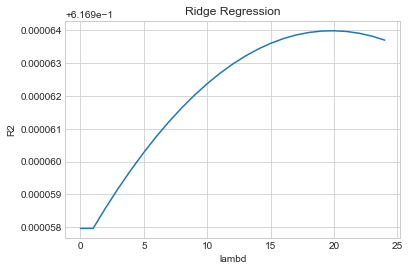

In [411]:
# Inspect and Adjust Parameter in Ridge Regression for testing

# Store estimates

scores = np.append(cross_val_score(ridgeregr, X_trainr, y_trainr, cv=kf).mean(),[0])

#Run the model for many alphas

for lambd in range(1, 25):
    ridgeregr = Ridge(alpha=lambd)
    ridgeregr.fit(X_trainr, y_trainr)
    scores = np.row_stack((
        scores,np.append(cross_val_score(ridgeregr, X_trainr, y_trainr, cv=kf).mean(),[lambd])))
 
# Make the data pretty

scores_df = pd.DataFrame(
    scores,columns = ['R2','lambd'])
scores_df.sort_values(by='lambd', inplace=True, ascending=True)

#Plot changes in R2 vs lambda

plt.plot(scores_df['lambd'], scores_df['R2'])
plt.title('Ridge Regression')
plt.xlabel('lambd')
plt.ylabel('R2')

In [412]:
# Testing the Ridge Regression.


ridgeregr1 = Ridge(alpha=18)

# Fit the model.
fit = ridgeregr1.fit(X_testr, y_testr)

#Predict the value of y
y_pred = ridgeregr1.predict(X_testr)

lin_mse = mean_squared_error(y_pred, y_testr)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)
cross_val_score(ridgeregr, X_testr, y_testr, cv=kf).mean()

Linear Regression RMSE: 0.3115


0.62289090801939595

***Random Forest***

In [413]:
#Build the new features based on Feature Importance
X3 = X1[['Price_per_buildingarea','BuildingArea','u']]

#Split between train and test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y, test_size=0.3, random_state=0)

In [415]:
#Initialize and fit the model

abc = RandomForestRegressor()

#Create range of values to fit parameters

#k2 = ['mse','friedman_mse','mae']
#k4 = ['auto','sqrt','log2', None]
k3 = [50,100,150,200,250,300]

parameters = { #'criterion': k2,
              'n_estimators': k3,
             #'max_features': k4
}

#Fit parameters

clf = GridSearchCV(abc, param_grid=parameters, cv=10)

clf.fit(X_trainr,y_trainr)
cross_val_score(clf, X_trainr, y_trainr, cv=kf).mean()

0.88514969635442298

In [420]:
#Predict the value of y
y_pred = clf.predict(X_testr)

lin_mse = mean_squared_error(y_pred, y_testr)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)
cross_val_score(clf, X_testr, y_testr, cv=kf).mean()

Linear Regression RMSE: 0.1683


0.88110312280864878

***Decision Tree***

In [421]:
#Initialize and fit the model

rf = DecisionTreeRegressor()

#Create range of values to fit parameters

k1  =['best','random']
k2 = ['mse','friedman_mse','mae']
#k4 = ['auto','sqrt','log2', None]
parameters = { 'criterion': k2,
              'splitter': k1,
             #'max_features': k4
             }

#Fit parameters

rf1 = GridSearchCV(rf, param_grid=parameters, cv=10)


rf1.fit(X_trainr,y_trainr)
cross_val_score(rf1, X_trainr, y_trainr, cv=kf).mean()

0.7935604361558205

In [422]:
#Predict the value of y
y_pred = rf1.predict(X_testr)

lin_mse = mean_squared_error(y_pred, y_testr)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)
cross_val_score(rf1, X_testr, y_testr, cv=kf).mean()

Liner Regression RMSE: 0.2183


0.81028010026684139

***Gradient Boosting***

In [418]:
# Train model
GBR = GradientBoostingRegressor()

#k2 = ['ls','lad','huber','quantile']
k4 = [50,100,150,200,250,300]

parameters = { #'loss': k2,
             'n_estimators': k4}

#Fit parameters

GBR1 = GridSearchCV(GBR, param_grid=parameters, cv=10)

GBR1.fit(X_trainr, y_trainr)
cross_val_score(GBR1, X_trainr, y_trainr, cv=kf).mean()

0.8888415689931719

In [419]:
#Predict the value of y
y_pred = GBR1.predict(X_testr)

lin_mse = mean_squared_error(y_pred, y_testr)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)
cross_val_score(GBR1, X_testr, y_testr, cv=kf).mean()

Liner Regression RMSE: 0.1613


0.88758159557211658

The dataset contained the Melbourne real estate market prices for form 2016 until September 2017. To clean the dataset, first the data was analyzed and only the data for one complete year was taken (sept 2016 - sept 2017). Additionally, the data points that didn´t contain prices were eliminated and the rest of the missing data points were replaced by the median of the column. The price presented a skewed to the left distribution and to smoothen it into a normal distribution, the logarithm of the price was used as an output variable

The relationship between the variables was analyzed being Rooms, bedroom2 and bathroom the ones that showed a higher correlation with the price. From a "Rooms" variable perspective, there were outliers that were reducing the accuracy of the models, hence, all data points with more than 10 rooms were eliminated increasing the accuracy of all the models by approx. 5% (except KNN and random forest).
Feature selection was done with RFE, Feature importance and Lasso regression. The difference between them was significant, being the final set of features that is giving better accuracy the one obtained through feature importance using random fores.:
Linear regression, randomforest, Decisiontreeregression, KNN and gradient boosting models were set on the training set and the hyperparameters were tuned. The model were passed through the test set.

The results for each of the models in the testset are:
Linear regression (Lasso): 0.619
Linear regression (ridge): 0623
Random Forest: 0.881
Decision Tree: 0.81
Gradient Boost: 0.887
Hence, the best model from an accuracy perspective is the Gradient Boosting model with an 88.7% accuracy